# CAIPI Denoising

TODO

- Add tensorboard functionality
- Design more models
- Add performance metrics - PSNR, SSIM
- Add more data augmentation methods

In [1]:
# Notebook imports

import warnings
warnings.filterwarnings('ignore')

import sys
import logging
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Refresh before importing python scripts
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rc('image', cmap='gray')

# LOGGING WHEN NOTEBOOK DISCONNECTS
nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

print(tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

2022-06-28 14:25:14.076312: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Autosaving every 5 seconds
2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


2022-06-28 14:25:15.001716: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [4]:
PREPROCESSED_SAVE_PATH = '/home/quahb/caipi_denoising/data/preprocessed'

PATCH_SIZE = (32, 32)
EXTRACT_STEP = (32, 32)
PAD_VALUE = -0.5
train_preprocessing_params = {
    'normalize': {},
    
    'pad_square': {
        'value': PAD_VALUE
    },
    
    'white_noise': {
        'mu': 0.0,
        'sigma': 0.15
    },
    
    'extract_patches': {
        'patch_size': PATCH_SIZE,
        'extract_step': EXTRACT_STEP,
        'pad_before_ext': False,
        'pad_value': PAD_VALUE,
    },
    
}

# extract patches before white noise if pad_before_ext==True
# we can add white noise to loaded patches
X_train_ops = [
    'normalize', 
    'pad_square', 
    'extract_patches', 
    'white_noise',
]

y_train_ops = [
    'normalize', 
    'pad_square', 
    'extract_patches',
]

test_preprocessing_params = {
    'normalize': {},
    
    'pad_square': {},
    
    'white_noise': {},
    
    'extract_patches': {
        'patch_size': PATCH_SIZE,
        'extract_step': (1, 1),  # should always be 1, 1 for reconstruction
        'pad_before_ext': True
    },
    
}

X_test_ops = ['extract_patches']


GPUS_TO_USE = ["/GPU:0", "/GPU:1", "/GPU:2", "/GPU:3"]
MODEL_INPUT_SHAPE = (None, ) + PATCH_SIZE + (1, ) if 'extract_patches' in X_train_ops else (None, 384, 384, 1)
VALID_SPLIT = 0.8
MODEL_TYPE = 0
PATIENCE = 5
MODEL_PATH='/home/quahb/caipi_denoising/models'
MODEL_FILENAME='denoiser_ep{epoch:02d}.h5'

BATCH_SIZE = 20
N_EPOCHS = 20
INIT_EPOCH = 0

# Load Training Data

In [5]:
from src.preparation.gen_data import get_data_dict, get_train_data, get_median_slices

In [6]:
X_train, y_train = get_train_data(median_slices=False)

# Plot median slices for each subject

In [ ]:
#print(dicoms_dict.keys(), dicoms_dict['1_01_016-V1'].keys(), len(dicoms_dict['1_01_016-V1']['3D_T2STAR_segEPI']))

# Plot median slice for each subject for single modality

dicoms_dict = get_data_dict('/home/quahb/caipi_denoising/data/data.json')

def plot_subj_slices(modality=0):
    MODALITY = modality 
    N_SLICES = X_train.shape[0]
    LEFT_i, MEDIAN_i, RIGHT_i = 35, 128, 221
    subj_list = list(dicoms_dict.keys())

    columns = 4
    rows    = len(subj_list) // columns + 1

    plt.figure(figsize=(23,120))
    for i in range(len(subj_list)):    
        plt.subplot(rows, columns, i + 1)
        plt.title(subj_list[i])

        plt.imshow(X_train[i * 256 + MEDIAN_i], cmap=plt.cm.gray)
        
#plot_subj_slices(0) # ['3D_T2STAR_segEPI', 'CAIPI1x2', 'CAIPI1x3', 'CAIPI2x2']

# Preprocess Training Data

In [7]:
from src.preparation.np_preprocessing_pipeline import preprocess_data

In [8]:
X_train.shape, y_train.shape

((16128, 384, 312, 1), (16128, 384, 312, 1))

In [ ]:
shuffle_idx = np.random.permutation(len(X_train))

In [9]:
X_train_pp = preprocess_data(X_train,
                             train_preprocessing_params,
                             ops=X_train_ops,
                             shuffle=shuffle_idx,
                             save_path=PREPROCESSED_SAVE_PATH)

NameError: name 'os' is not defined

In [12]:
y_train_pp = preprocess_data(y_train,
                             train_preprocessing_params,
                             ops=y_train_ops,
                             shuffle=shuffle_idx,
                             save_path=PREPROCESSED_SAVE_PATH)

(16128, 384, 384, 1)

## Plot Preprocessed X_train vs y_train

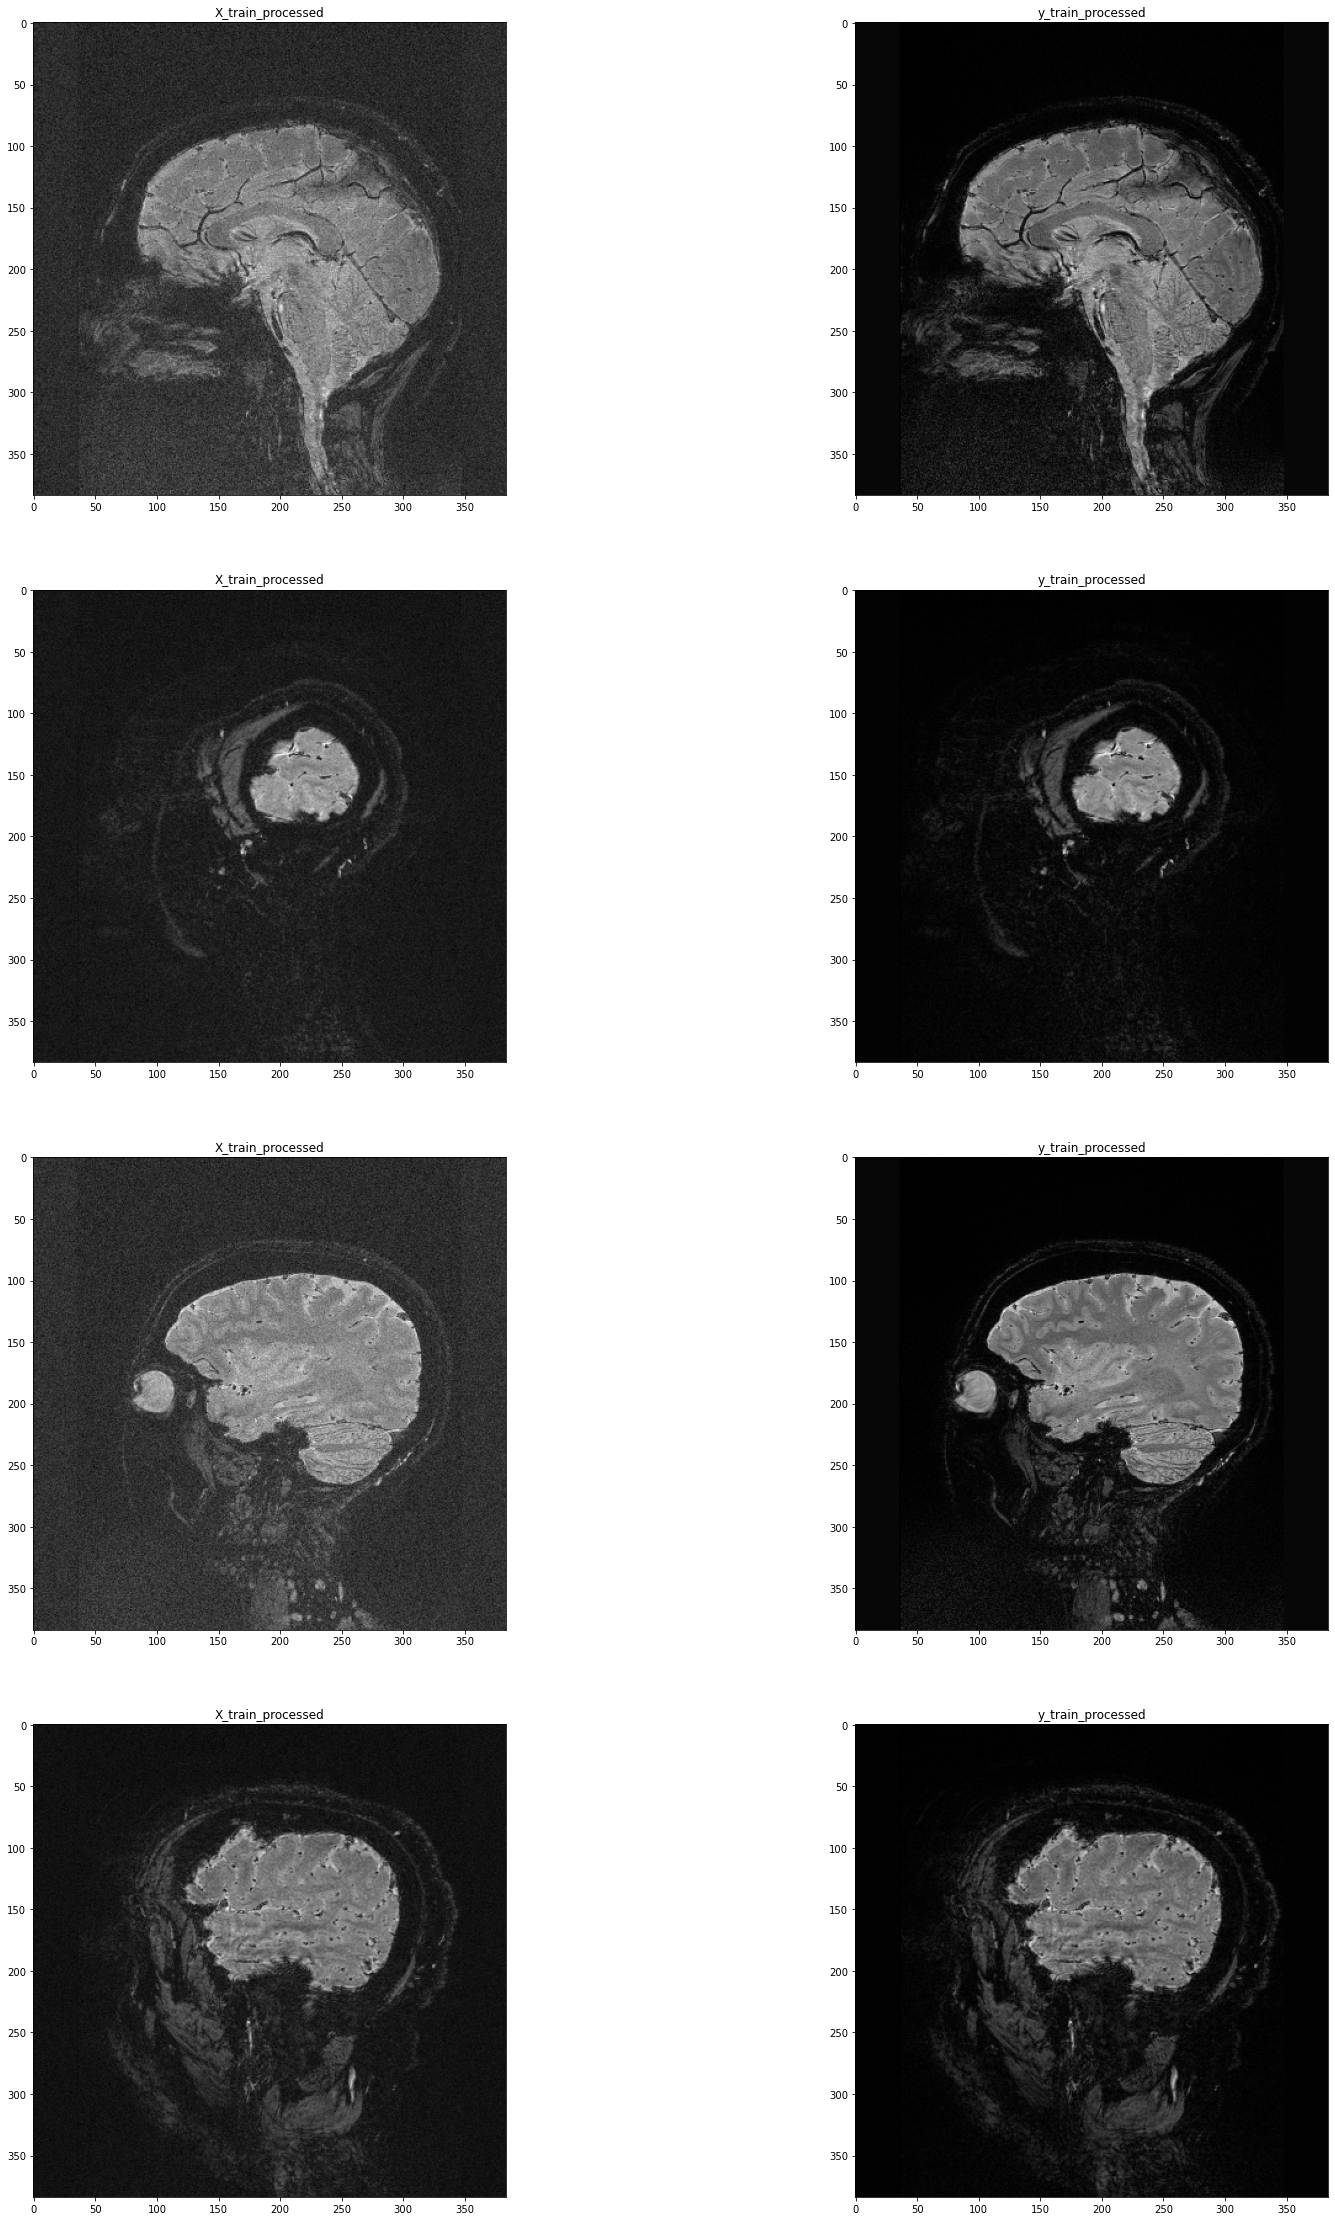

In [13]:
def plot_pp_io():
    cols = 2
    rows = 4

    plt.figure(figsize=(27,40))
    plt_i = 0
    for i in range(16, 20):  # range of slices to view
        plt.subplot(rows, cols, plt_i + 1)
        plt.title('X_train_processed')
        plt.imshow(X_train_pp[i], cmap=plt.cm.gray)

        plt.subplot(rows, cols, plt_i + 2)
        plt.title('y_train_processed')
        plt.imshow(y_train_pp[i], cmap=plt.cm.gray)

        plt_i += 2
    
plot_pp_io()

In [14]:
valid_i = int(len(X_train_pp) * VALID_SPLIT)

X_train_f, y_train_f = X_train_pp[:valid_i], y_train_pp[:valid_i]
X_valid_f, y_valid_f = X_train_pp[valid_i:], y_train_pp[valid_i:]

In [15]:
X_train_f.shape, y_train_f.shape, X_valid_f.shape, y_valid_f.shape

((12902, 384, 384, 1),
 (12902, 384, 384, 1),
 (3226, 384, 384, 1),
 (3226, 384, 384, 1))

# Model Instantiation

In [16]:
import tensorflow as tf
from src.modeling.get_model import get_model
from src.modeling.callbacks import get_training_cb

In [21]:
strategy = tf.distribute.MirroredStrategy(devices=GPUS_TO_USE)

with strategy.scope():
    model = get_model(model_type=MODEL_TYPE, 
                      input_shape=MODEL_INPUT_SHAPE)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


# Model Training

In [23]:
cb_list = get_training_cb(patience=PATIENCE,
                          save_path=MODEL_PATH, 
                          save_filename=MODEL_FILENAME)

In [24]:
model.summary()

Model: "denoiser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 24, 24, 32)        391776    
_________________________________________________________________
sequential_1 (Sequential)    (None, 384, 384, 1)       400993    
Total params: 792,769
Trainable params: 790,849
Non-trainable params: 1,920
_________________________________________________________________


In [25]:
%%time

history = model.fit(X_train_f, y_train_f,
                    validation_data=(X_valid_f, y_valid_f),
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS,
                    initial_epoch=INIT_EPOCH,
                    callbacks=cb_list,
                    shuffle=True)
print(history)

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 34 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 34 all-reduces with algorithm = nccl, num_packs = 1
646/646 [==============================] - 1641s 1s/step - loss: 0.5038 - val_loss: 0.4770

Epoch 00001: loss improved from inf to 0.48939, saving model to /home/quahb/caipi_denoising/models/2022-06-23/denoiser_ep01.h5
Epoch 2/20
646/646 [==============================] - 97s 150ms/step - loss: 0.4752 - val_loss: 0.4743

Epoch 00002: loss improved from 0.48939 to 0.47990, saving model to /home/quahb/caipi_denoising/models/2022-06-23/denoiser_ep02.h5
Epoch 3/20
646/646 [==============================] - 101s 156ms/step - loss: 0.4791 - val_loss: 0.4773

Epoch 00003: loss improved from 0.47990 to 0.47778, saving model to /home/quahb/caipi_denoising/models/2022-06-23/denoiser_ep03.h5
Epoch 4/20
646/646 [==============================] - 100s 155ms/step - loss: 0.4811 - val_loss: 0.4885

Epoch 00004: loss impr

KeyboardInterrupt: 

In [ ]:
#model.load_weights(r'/home/quahb/caipi_denoising/models/2022-06-10/denoiser_ep06.h5')

# Preprocess Testing Data

In [ ]:
from src.preparation.gen_data import get_test_data

In [ ]:
X_test = get_test_data()

In [ ]:
X_test = preprocess_data(X_test, test_preprocessing_params, 
                         X_ops=X_test_ops,
                         shuffle=True)

# Run model inference

In [ ]:
X_test.shape

In [ ]:
SHOW_N_SLICES = 50
y_test = model.predict(X_test[:SHOW_N_SLICES],
                       verbose=1,
                       batch_size=30)

In [ ]:
print(np.min(X_test[0]), np.max(X_test[0]), np.mean(X_test[0]))
print(np.min(y_test[0]), np.max(y_test[0]), np.mean(y_test[0]))

In [ ]:
np.random.shuffle(y_test)
y_mini = y_test[:50]

In [ ]:
plt.figure(figsize=(28, 55))
columns = 2
rows = 25
SHOW_N_SLICES = 50

for i in range(46, y_test.shape[0], 2):
    input_slc = X_test[i]
    output_slc = y_test[i]
    
    plt.subplot(rows, columns, i + 1)
    plt.imshow(input_slc, cmap='gray')
    plt.subplot(rows, columns, i + 2)
    plt.imshow(output_slc, cmap='gray')

In [ ]:
plt.figure(figsize=(30,70))
columns = 2
SHOW_N_SLICES = 50

for i in range(46, y_test.shape[0], 2):
    input_slc = X_test[i]
    output_slc = y_test[i]
    
    plt.subplot(y_test.shape[0] // columns + 1, columns, i + 1)
    plt.imshow(input_slc, cmap='gray')
    plt.subplot(y_test.shape[0] // columns + 1, columns, i + 2)
    plt.imshow(output_slc, cmap='gray')